This notebooks uses the following dataset <br>
https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

# 1. Analysis of the Problem

## Understand the problem

working hypothesis
think about model architecture
loss function
and loss criteria

select a measure of success
    Detect all classes/types of hand gestures with a high accuracy
    Classification Problem
    Check whether class-imbalanced problems

Dataset with class of the hand gesture/'Class' (our target value) the person which performed the hand gesture ('User') and a 
feature vector that consists 11 subvectors. Each subvector contains X, Y and Z coordinates. Those coordinates belong to one of the detected markes on the hand glove the user is wearing

* motion capture camera records 12 users performing 5 hand postures with markers attached to a left-handed glove
* rigid pattern of markers on the back of the glove -> establish local coordinate system for the hand
* 11 markers were attached to the thumb and fingers of the glove
* there is no a priori correspondence between the markers of two given records
* due to the resolution of the capture volume and self-occlusion due to the orientation and configuration of the hand and fingers, many records have missing markers.
    -> the number of visible markers in a record varied considerably.


The Problem:
We cannot easily apply traditional approaches because of two properties of point clouds:
* unordered collection (Point 1 with X,Y and Z coordinates could refer to the thh )
* the size of the point cloud varies (due to occlusion, etc.)

## Useful Information from the authors/paper

Preprocessing:<br>
all markers were transformed to the local coordinate system of the record containing them.

Reduce number of records:<br>
each transformed marker with a norm greater than 200 millimeters was pruned. 
records that contained fewer than 3 markers was removed. 
the data has at most 12 markers per record and at least 3

Be careful:<br>
It is likely that for a given record and user there exists a near duplicate record originating from the same user.
-> evaluate on leave-one-user-out basis wherein

## Ideas I want to try out

My goal: posture recognition via classification

# 2. Data Exploration and Preparation

Check for missing values, NaN values or features,
uniqueness of the data (is it as it was expected to be)
understand the variations in the data (statistical tools)
outliers?
Is it possible to combine features?
Do you have unnecessary features? (a column which gives no information – for instance name
column– or a feature you consider unrelated to the problem)
Check the correlation matrix. It will tell you how much the features are related. You may say,
for instance, there is a great potential to reduce number of dimensions.
scale data (for example, in the [-1, 1] range).

## Preparing the enviroment

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import time
import seaborn as sns
#from numpy import nan
#import math
#from sklearn.decomposition import PCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scripts import analyze_helper, visualisation
from sklearn.model_selection import train_test_split

## Loading the Data

In [116]:
file_path_raw = os.path.join('data', 'Postures.csv')
df_raw = pd.read_csv(file_path_raw, sep=',', na_values='?')

## Data Exploration

In [117]:
df_raw.columns

Index(['Class', 'User', 'X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2',
       'X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6',
       'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10',
       'Z10', 'X11', 'Y11', 'Z11'],
      dtype='object')

In [118]:
# Check which columns have missing values
print(f"Missing values in: {analyze_helper.check_for_missing_vals(df_raw)}")
# Compute missing ratio, hide columns with no missing values (0.0%)
analyze_helper.compute_missing_ratio(df_raw)

Missing values in: ['X3', 'Y3', 'Z3', 'X4', 'Y4', 'Z4', 'X5', 'Y5', 'Z5', 'X6', 'Y6', 'Z6', 'X7', 'Y7', 'Z7', 'X8', 'Y8', 'Z8', 'X9', 'Y9', 'Z9', 'X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11']


X3      0.88
Y3      0.88
Z3      0.88
X4      4.00
Y4      4.00
Z4      4.00
X5     16.68
Y5     16.68
Z5     16.68
X6     33.10
Y6     33.10
Z6     33.10
X7     50.13
Y7     50.13
Z7     50.13
X8     60.86
Y8     60.86
Z8     60.86
X9     69.31
Y9     69.31
Z9     69.31
X10    81.11
Y10    81.11
Z10    81.11
X11    99.96
Y11    99.96
Z11    99.96
Name: percent_missing, dtype: float64

Hint for preprocessing:
drop the coordinates (X,Y,Z) for point 10 and 11

In [119]:
df_raw = df_raw.fillna(0)

In [120]:
df_raw.head(5)
df_raw.drop([0], inplace=True)
df_raw.reset_index(drop=True, inplace=True)

In [121]:
print('Number of Instances  : ', df_raw.shape[0])
print('Number of Attributes : ', df_raw.shape[1])
print('Number of target classes   : ', df_raw['Class'].nunique()-1)
print('Number of users   : ', df_raw['User'].nunique())

Number of Instances  :  78095
Number of Attributes :  38
Number of target classes   :  4
Number of users   :  14


The description says the data set contains 12 User. No information provided (why are 14 user in the data?).
Hint for us to drop User 4 and 7 ?
They both have signifiantly less data points

In [122]:
user_group = df_raw.groupby(['User'], sort=False)
user_group.count()

,Class,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
User,,,,,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,...,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,...,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,...,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
4,379,379,379,379,379,379,379,379,379,379,...,379,379,379,379,379,379,379,379,379,379
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,...,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,...,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
7,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,...,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,...,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920


In [123]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78095 entries, 0 to 78094
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   78095 non-null  int64  
 1   User    78095 non-null  int64  
 2   X0      78095 non-null  float64
 3   Y0      78095 non-null  float64
 4   Z0      78095 non-null  float64
 5   X1      78095 non-null  float64
 6   Y1      78095 non-null  float64
 7   Z1      78095 non-null  float64
 8   X2      78095 non-null  float64
 9   Y2      78095 non-null  float64
 10  Z2      78095 non-null  float64
 11  X3      78095 non-null  float64
 12  Y3      78095 non-null  float64
 13  Z3      78095 non-null  float64
 14  X4      78095 non-null  float64
 15  Y4      78095 non-null  float64
 16  Z4      78095 non-null  float64
 17  X5      78095 non-null  float64
 18  Y5      78095 non-null  float64
 19  Z5      78095 non-null  float64
 20  X6      78095 non-null  float64
 21  Y6      78095 non-null  float64
 22

### Data Visualization

In [124]:
def pltHand(handPoints):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    for i in range(11):
        pntx = f'X{i}'
        pnty = f'Y{i}'
        pntz = f'Z{i}'
        
        if(handPoints[pntx].values[0] == 0 or
            handPoints[pnty].values[0] == 0 or
            handPoints[pntz].values[0] == 0):
            n = 0;
        else:
            xlocation = handPoints[pntx]
            ylocation = handPoints[pnty]
            zlocation = handPoints[pntz]
            ax.scatter(xlocation, ylocation, zlocation, marker='v')
    
    crntClass = handPoints['Class'].values[0]
    if (crntClass == 1):
        title = 'Fist + Thumb out'
    if(crntClass == 2):
        title = 'Stop/Flat hand'
    if (crntClass == 3):
        title = 'Point with pointer finger'
    if (crntClass == 4):
        title = 'Point with pointer + middle finger'
    if (crntClass == 5):
        title = 'Grab'
    
    plt.title(title)
    plt.show()


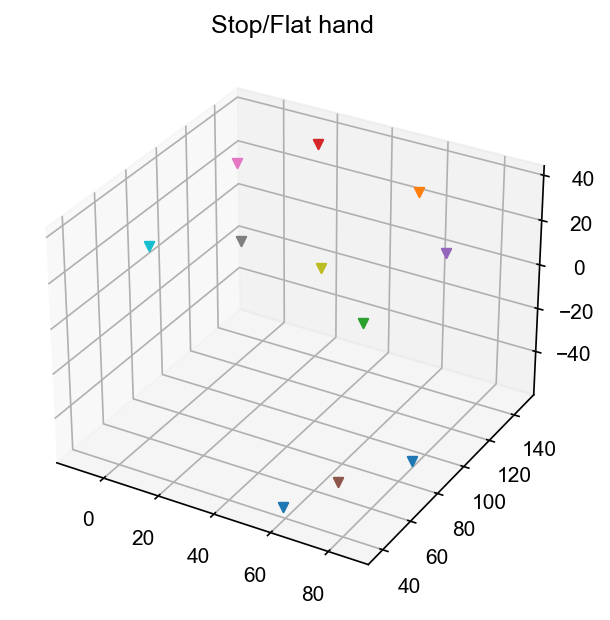

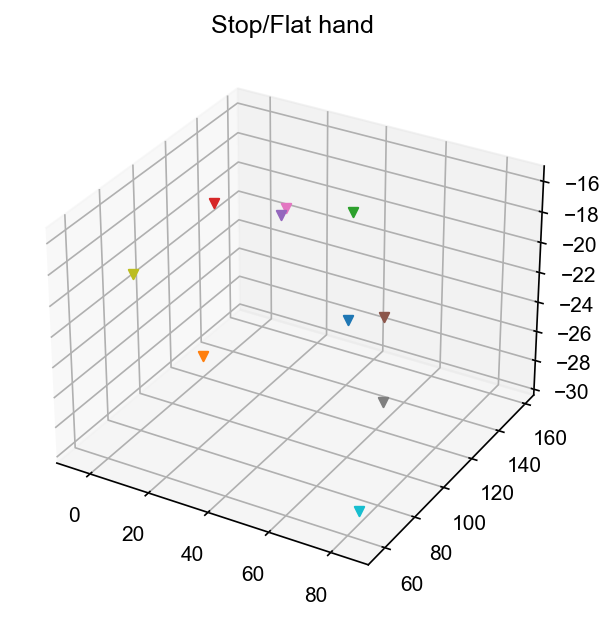

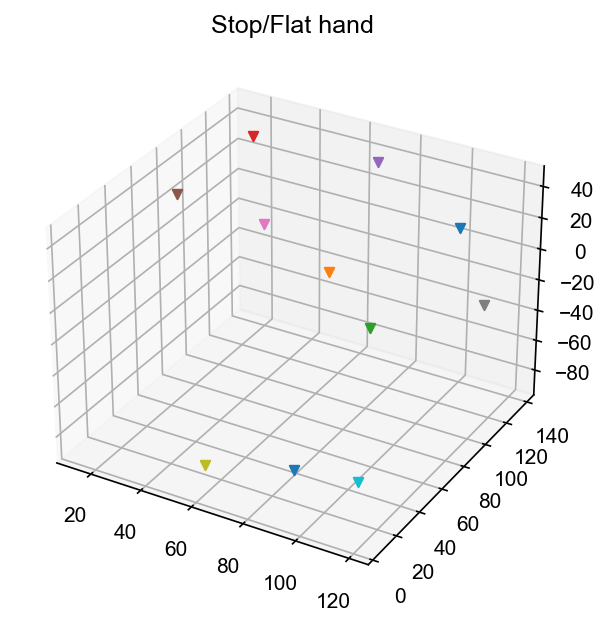

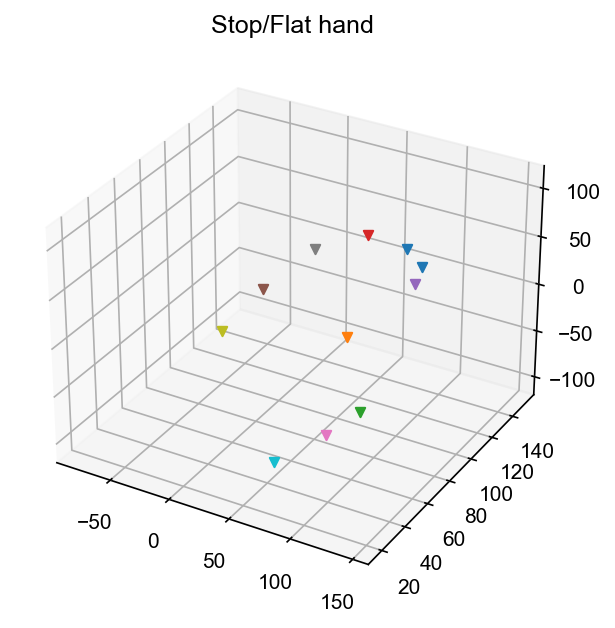

In [125]:
# Plot a random hand gesture from the dataset to get a an idea of the data
for _ in range(4):
    rand_dp = np.random.randint(df_raw.shape[0], size=1)[0]
    pltHand(df_raw[rand_dp:rand_dp+1] )

In [126]:
def correlation_matrix(df: pd.DataFrame):

    correlationMatrix = pd.DataFrame(df_raw).corr() 
    f = plt.figure(figsize=(12, 6))
    plt.matshow(correlationMatrix, fignum=f.number)
    plt.xticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14, rotation=75)
    plt.yticks(range(df_raw.shape[1]), df_raw.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.show()

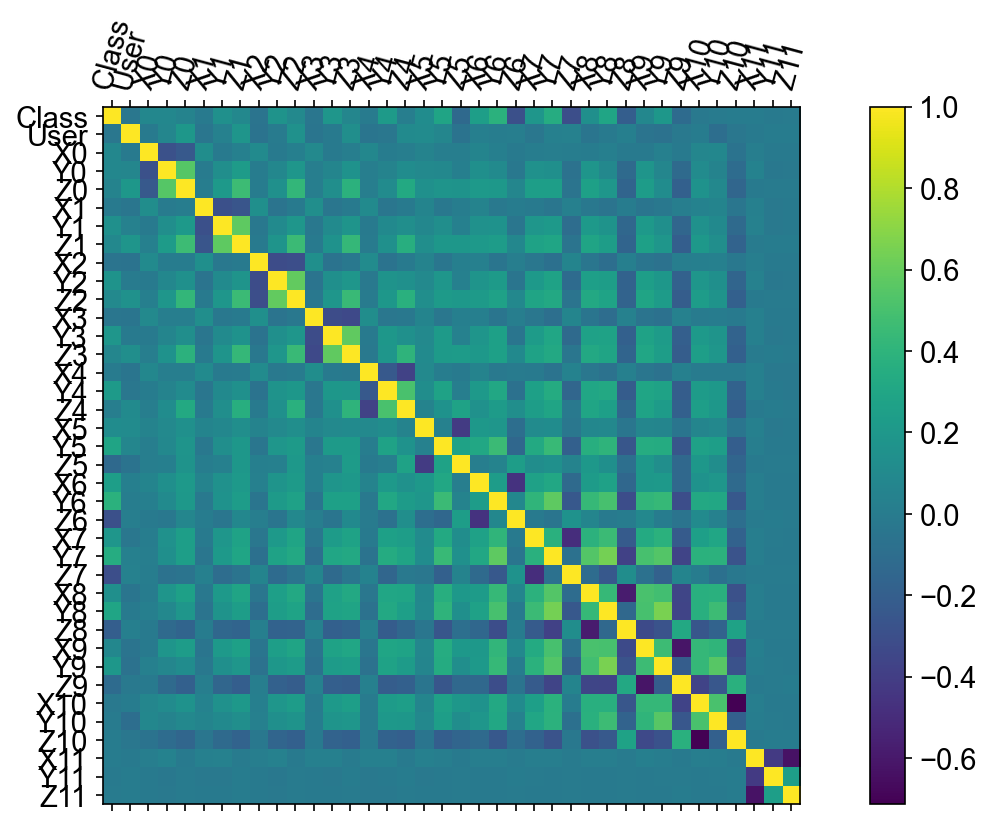

In [127]:
correlation_matrix(df_raw)

## Pre-processing



## General

In [128]:
# Drop rows of user 4 and 7
df_raw = df_raw[df_raw['User'] != 4]
df_raw = df_raw[df_raw['User'] != 7]
df_raw.reset_index(drop=True, inplace=True)

### Preparing Dataset

### a. Extract features (min, max, mean, etc.) - df_aggregate

Ideas for new features: (inspired from paper)<br>
* number of markers
* mean (per coordinate)
* Eigenvalues and vectors of the points covariance matrix
https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give
* dimensions of the axis-aligned minimum bounding box centered on the mean

Keep in mind that each feature has to aggregate the points in such a way that the result is order invariant!


In [130]:
# New data set we want to fill step by step
df_aggregate= pd.DataFrame()
# We dont want to change the original data set
df_raw_dummy = df_raw.copy(deep=True)

# Save the user and class column
df_user = df_raw_dummy.pop('User')
df_class = df_raw_dummy.pop('Class')


In [131]:
# Extract the X, Y and Z columns
df_x = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('X')]]
df_y = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Y')]]
df_z = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith('Z')]]

In [132]:
# Extract the mean of the X, Y and Z columns
for coordinate in ['X', 'Y', 'Z']:
    df_aggregate[f'{coordinate}_mean'] = df_raw_dummy[df_raw_dummy.columns[pd.Series(df_raw_dummy.columns).str.startswith(coordinate)]].mean(axis=1)

In [133]:
# Extract the number of visible points (not occluded)
df_aggregate['n_points'] = (df_raw_dummy.astype(bool).sum(axis=1))/3
df_aggregate

,X_mean,Y_mean,Z_mean,n_points
0,26.016799,22.836499,-27.957453,5.0
1,26.993800,23.186663,-26.753805,5.0
2,26.734339,23.280765,-26.987933,5.0
3,26.432960,22.979929,-27.470148,5.0
4,26.329043,22.846808,-27.662696,5.0
...,...,...,...,...
77219,23.186392,81.073422,-24.211700,10.0
77220,23.351640,80.993151,-24.373615,10.0
77221,23.419704,80.794642,-24.779234,10.0
77222,16.986696,78.041537,-21.130303,9.0


In [134]:
df_raw_dummy

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272,85.232264,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489,87.450873,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489,86.835388,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461,61.596157,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743,86.368748,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,-46.460186,-1.901940,...,-6.543115,87.733364,61.216363,-62.126278,0.0,0.0,0.0,0.0,0.0,0.0
77220,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,-17.002723,-22.743924,...,-62.130563,78.229847,33.078407,-45.249543,0.0,0.0,0.0,0.0,0.0,0.0
77221,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,-53.939140,-30.225675,...,3.835904,78.591554,32.327738,-46.166556,0.0,0.0,0.0,0.0,0.0,0.0
77222,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,-17.460853,26.715915,...,-63.221626,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


My idea:<br>
find the orientation of a given cluster<br>
(https://math.stackexchange.com/questions/2842830/why-does-the-eigen-decomposition-of-the-covariance-matrix-of-a-point-cloud-give)

1. Rearange the dataset (1 point per row)
-> All points per row will be saved in a batch as new sub dataframe
2. Compute the covariance matrix for each sub dataframe
3. Calculate the Eigenvalues and Eigenvectors of the covariance matrix
4. Concat created features to the dataframe


In [135]:

# Assume you have a DataFrame called 'df' with the columns ['X0', 'Y0', 'Z0', 'X1', 'Y1', 'Z1', 'X2', 'Y2', 'Z2']
# Reorganize the dataframe to have each row as a batch of data
# 'X0', 'Y0', 'Z0',
# 'X1', 'Y1', 'Z1',
# 'X2', 'Y2', 'Z2'

# Create an empty list to store the batches of data
batches = []

# Iterate over the DataFrame and extract the batches of data
for row in range(0, df_raw_dummy.shape[0]):

    col_batch = []
    # Extract a batch of data for the current row
    for col in range(0, df_raw_dummy.shape[1], 3):
        batch = df_raw_dummy.iloc[row, col:col+3]
        # Rename the columns
        batch.index = ['X', 'Y', 'Z']
        #print(f'batch: {batch}')
        col_batch.append(batch)
    # Append the batch to the list
    batches.append(col_batch)

# Concatenate the batches of data under each other
concat_batches = []
for batch in batches:
    concat_batch = pd.concat(batch, axis=1).transpose()
    concat_batches.append(concat_batch)
    # Remove rows with all zeros
    concat_batch = concat_batch[(concat_batch.T != 0).any()]

# Create a dictionary with the eigenvalues and eigenvectors as values
eigen_dict = {'eigenvec_1_1': [],
                'eigenvec_1_2': [],
                'eigenvec_1_3': [],
                'eigenvec_2_1': [],
                'eigenvec_2_2': [],
                'eigenvec_2_3': [],
                'eigenvec_3_1': [],
                'eigenvec_3_2': [],
                'eigenvec_3_3': [],
              'eigenval_1': [],
              'eigenval_2': [],
              'eigenval_3': []}

# Create the DataFrame
eigen_df = pd.DataFrame(eigen_dict)

# Compute the covariance matrix for each batch
for concat_batch in concat_batches:
    # Compute the covariance matrix
    cov_matrix = np.cov(concat_batch, rowvar=False)
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Add the eigenvalues and eigenvectors to the DataFrame
    # Store eigenvector 1
    eigen_dict['eigenvec_1_1'].append(eigenvectors[0, 0])
    eigen_dict['eigenvec_1_2'].append(eigenvectors[1, 0])
    eigen_dict['eigenvec_1_3'].append(eigenvectors[2, 0])
    # Store eigenvector 2
    eigen_dict['eigenvec_2_1'].append(eigenvectors[0, 1])
    eigen_dict['eigenvec_2_2'].append(eigenvectors[1, 1])
    eigen_dict['eigenvec_2_3'].append(eigenvectors[2, 1])
    # Store eigenvector 3
    eigen_dict['eigenvec_3_1'].append(eigenvectors[0, 2])
    eigen_dict['eigenvec_3_2'].append(eigenvectors[1, 2])
    eigen_dict['eigenvec_3_3'].append(eigenvectors[2, 2])
    # Store eigenvalues
    eigen_dict['eigenval_1'].append(eigenvalues[0])
    eigen_dict['eigenval_2'].append(eigenvalues[1])
    eigen_dict['eigenval_3'].append(eigenvalues[2])

# Finally add generated features to the DataFrame
df_aggregate = pd.concat([df_aggregate, pd.DataFrame(eigen_dict)], axis=1)

In [182]:
batches[0][0].to_numpy()
shape = (len(batches), 3)
print(shape)
X_set = np.ndarray(shape = shape)
for batch in batches:
    for col in batch:
        np.append(X_set ,col.to_numpy())

#TODO not used rigth now


(77224, 3)


In [136]:
df_aggregate
#TODO remove header from second df

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3
0,26.016799,22.836499,-27.957453,5.0,-0.591234,-0.524439,0.612704,-0.681147,-0.082077,-0.727532,-0.431834,0.847483,0.308693,3134.622529,25.606909,321.857698
1,26.993800,23.186663,-26.753805,5.0,-0.611912,-0.531215,0.585981,-0.661710,-0.061995,-0.747193,-0.433248,0.844966,0.313574,3139.094666,22.090213,321.765952
2,26.734339,23.280765,-26.987933,5.0,-0.605440,-0.533360,0.590737,-0.659977,-0.078396,-0.747185,-0.444830,0.842248,0.304541,3143.632148,22.268614,323.292572
3,26.432960,22.979929,-27.470148,5.0,-0.599461,-0.527178,0.602270,-0.657370,-0.105005,-0.746216,-0.456631,0.843242,0.283605,3137.143213,22.814897,322.034868
4,26.329043,22.846808,-27.662696,5.0,-0.597594,-0.524540,0.606415,-0.659195,-0.109140,-0.744010,-0.456447,0.844362,0.280553,3135.719734,24.226284,322.014274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,23.186392,81.073422,-24.211700,10.0,-0.295829,-0.170505,-0.939901,0.949887,-0.156541,-0.270574,0.100999,0.972843,-0.208270,490.966369,1622.222428,2328.190234
77220,23.351640,80.993151,-24.373615,10.0,-0.306397,-0.166093,-0.937301,0.947568,-0.147096,-0.283687,0.090755,0.975077,-0.202454,496.364736,1646.474868,2330.621694
77221,23.419704,80.794642,-24.779234,10.0,-0.311902,-0.166501,-0.935411,-0.946236,0.143302,0.290004,-0.085761,-0.975573,0.202246,502.512612,1652.381296,2332.510840
77222,16.986696,78.041537,-21.130303,9.0,0.265099,0.925401,-0.270840,0.940359,-0.310233,-0.139572,0.213184,0.217687,0.952452,2922.111365,1180.129354,484.118696


In [137]:
# Add user and class information to the new data set after the feature extraction
df_aggregate['User'] = df_user
df_aggregate['Class'] = df_class

In [138]:
# Same with new extracted features
X_train_agg = df_aggregate.loc[(df_aggregate['User'] <=4) ]
y_train_agg = X_train_agg.pop('Class')

X_test_agg= df_aggregate.loc[(df_aggregate['User'] > 4) ]
y_test_agg = X_test_agg.pop('Class')

In [171]:
import random

def get_train_test_user(user_list:list):
    # TODO make number of random users variable and make user_list variable + pop users from list that are already picked once
    '''This function returns the indices for the training and test set.
    The function randomly selects two users for the test set and the remaining
    users for the training set.
    
    return: train_indices, test_indices'''

    # Create a list of indices for the training and test set
    train_indices = []
    test_indices = []
    
    # Generate 2 random numbers between 0 and 14
    test_user_1, test_user_2 = random.sample(user_list, 2)
    print(f'User picked for test set: {test_user_1}, {test_user_2}')
    

    # Iterate over the users
    for user in user_list:
        # Get the indices for the current user
        indices = df_aggregate[df_aggregate['User'] == user].index
        # Append the indices to the list
        if user == test_user_1 or user == test_user_2:
            test_indices.extend(indices)
        else:
            train_indices.extend(indices)
    
    # Remove the test users from the user list so they cannot be selected again
    user_list = [x for x in user_list if x != test_user_1 and x != test_user_2]

    return train_indices, test_indices, user_list

def custom_cv_approach(user_list:list):
    
    # Get the indices for the training and test set
    train_indices, test_indices, user_list = get_train_test_user(user_list)
    print(f'train_indices examples: {len(train_indices)}')
    print(f'test_indices examples: {len(test_indices)}')
    # Create the training and test set
    X_train = df_aggregate.iloc[train_indices, :]
    y_train = X_train.pop('Class')
    X_test = df_aggregate.iloc[test_indices, :]
    y_test = X_test.pop('Class')

    return X_train, y_train, X_test, y_test, user_list



In [140]:
user_group = df_aggregate.groupby(['User'], sort=False)
user_group.count()

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,Class
User,,,,,,,,,,,,,,,,,
0,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048,9048
1,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717
2,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
5,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
6,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377,4377
8,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811,6811
9,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920,3920
10,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573,9573
11,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061,8061


In [ ]:
#TODO add augmentation to the data set.
# e.g. add Jitter or Shuffle data

### b. Demonstration data set (WRONG WAY) - mixed user

******************************************************
DEMONSTRATION: this shows how NOT to do it:<br>
Splitting the naive way (similar data points will be in both sets)
******************************************************

In [141]:
df_raw

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,5,14,54.251127,129.177414,-44.252511,27.720784,107.810661,11.099282,-1.270139,122.758679,...,-6.543115,87.733364,61.216363,-62.126278,0.0,0.0,0.0,0.0,0.0,0.0
77220,5,14,54.334883,129.253842,-44.016320,27.767911,107.914808,11.069842,-30.334054,77.858214,...,-62.130563,78.229847,33.078407,-45.249543,0.0,0.0,0.0,0.0,0.0,0.0
77221,5,14,54.151540,129.269502,-44.173273,27.725978,108.034006,11.020347,-22.574718,104.222208,...,3.835904,78.591554,32.327738,-46.166556,0.0,0.0,0.0,0.0,0.0,0.0
77222,5,14,27.915311,108.007390,10.814957,-0.910435,122.464093,-47.271248,-30.084588,77.705861,...,-63.221626,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_raw, df_raw['Class'], test_size=0.25)
user_group = df_raw.groupby(['User'], sort=False)

each user is iteratively left out from training and used as a test set. One then tests the generalization of the algorithm to new users. A 'User' attribute is provided to accomodate this strategy. 

In [143]:
# Get Train and Test data with leave one user out strategy
# TODO create cross validation wrapper function and create multiple train and test sets (with different users)
X_train_new = df_raw.loc[(df_raw['User'] <=4) ]
y_train_new = X_train_new.pop('Class')

X_test_new = df_raw.loc[(df_raw['User'] > 4) ]
y_test_new = X_test_new.pop('Class')

label, standardisation

# 1. Testing Phase I: Baseline Models

## Random Forest Classifier

In [144]:
# Hyperparameters:
#You need to check model descriptions for the hyperparameters. 
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier
#-----------------------------------------------------------------
# Number of trees in the forest:
n_estimators = 10
# Number of features to consider when looking for the best split:
max_features = 'auto'
# Maximum depth of the tree:
max_depth = None
# Minimum number of samples required to split an internal node:
min_samples_split = 2
# Minimum number of samples required to be at a leaf node:
min_samples_leaf = 1
# Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. 
max_leaf_nodes = None
# Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree:
bootstrap = False
# Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
oob_score = False
# Number of jobs to run in parallel. (-1) means use all.
n_jobs = -1
# Random state
random_state = 2021
#-----------------------------------------------------------------
# Creating the classifier:
RFC = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                              max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,oob_score=oob_score, n_jobs=n_jobs, random_state=random_state)



### a) Mixed dataset

In [145]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=10, n_jobs=-1,
                       random_state=2021)

In [146]:
RFC.score(X_test, y_test)

0.9999482026313063

### b) Properly split - leave one user out strategy

In [147]:
RFC_new = RandomForestClassifier()

In [148]:
RFC_new.fit(X_train_new, y_train_new)

RandomForestClassifier()

In [149]:
RFC_new.score(X_test_new, y_test_new)

0.6532080209004852

In [150]:
RFC_agg = RandomForestClassifier()
RFC_agg.fit(X_train_agg, y_train_agg)
RFC_agg.score(X_test_agg, y_test_agg)

0.665524378244495

In [159]:
df_aggregate

,X_mean,Y_mean,Z_mean,n_points,eigenvec_1_1,eigenvec_1_2,eigenvec_1_3,eigenvec_2_1,eigenvec_2_2,eigenvec_2_3,eigenvec_3_1,eigenvec_3_2,eigenvec_3_3,eigenval_1,eigenval_2,eigenval_3,User,Class
0,26.016799,22.836499,-27.957453,5.0,-0.591234,-0.524439,0.612704,-0.681147,-0.082077,-0.727532,-0.431834,0.847483,0.308693,3134.622529,25.606909,321.857698,0,1
1,26.993800,23.186663,-26.753805,5.0,-0.611912,-0.531215,0.585981,-0.661710,-0.061995,-0.747193,-0.433248,0.844966,0.313574,3139.094666,22.090213,321.765952,0,1
2,26.734339,23.280765,-26.987933,5.0,-0.605440,-0.533360,0.590737,-0.659977,-0.078396,-0.747185,-0.444830,0.842248,0.304541,3143.632148,22.268614,323.292572,0,1
3,26.432960,22.979929,-27.470148,5.0,-0.599461,-0.527178,0.602270,-0.657370,-0.105005,-0.746216,-0.456631,0.843242,0.283605,3137.143213,22.814897,322.034868,0,1
4,26.329043,22.846808,-27.662696,5.0,-0.597594,-0.524540,0.606415,-0.659195,-0.109140,-0.744010,-0.456447,0.844362,0.280553,3135.719734,24.226284,322.014274,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77219,23.186392,81.073422,-24.211700,10.0,-0.295829,-0.170505,-0.939901,0.949887,-0.156541,-0.270574,0.100999,0.972843,-0.208270,490.966369,1622.222428,2328.190234,14,5
77220,23.351640,80.993151,-24.373615,10.0,-0.306397,-0.166093,-0.937301,0.947568,-0.147096,-0.283687,0.090755,0.975077,-0.202454,496.364736,1646.474868,2330.621694,14,5
77221,23.419704,80.794642,-24.779234,10.0,-0.311902,-0.166501,-0.935411,-0.946236,0.143302,0.290004,-0.085761,-0.975573,0.202246,502.512612,1652.381296,2332.510840,14,5
77222,16.986696,78.041537,-21.130303,9.0,0.265099,0.925401,-0.270840,0.940359,-0.310233,-0.139572,0.213184,0.217687,0.952452,2922.111365,1180.129354,484.118696,14,5


In [173]:
# With custom cross validation

# Create a list of users
user_list = [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14]

for i in range(4): #TODO make number of iterations variable

    RFC_custom = RandomForestClassifier()

    X_train, y_train, X_test, y_test, user_list = custom_cv_approach(user_list)
    RFC_custom.fit(X_train, y_train)
    print(RFC_custom.score(X_test, y_test))

train_indices examples: 63972
test_indices examples: 13252
0.8071989133715666
train_indices examples: 54490
test_indices examples: 9482
0.7574351402657667
train_indices examples: 35869
test_indices examples: 18621
0.8550561194350464
train_indices examples: 20997
test_indices examples: 14872
0.5322081764389457


# 4. Testing Phase II: Model Develepoment

Start with first Neural Network

# 5. Testing Phase III: Model Regularization and Hyperparameter optimization

This section is reserved for neural networks, Fine tune models
regularization
make notes of the trials
save plots
use CV to optimize the model
Add a brief description of this optimization process

# 6. Evaluation of the model predictions

###  All Models/Overall Comparison

# 7. Lessons Learnt and Conclusions

tell us what you found and what you learned!

Logistic Regression
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Gradient Descent

Random Forests

Boosting (LightGBM)
https://lightgbm.readthedocs.io/en/latest/

## Model 1


### Training

### Evaluation

Confusion Matrix
PR Curve
ROC Curve

### Discussion

## Model 2


### Training

### Evaluation

### Discussion